# Running Fatigue Analysis


In [3]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
url = 'https://raw.githubusercontent.com/Redback-Operations/redback-fit-sports-performance/main/Running_Archive/Fixed_cleaned_activities.csv'
df = pd.read_csv(url)

# Preview data
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (155, 33)


,Activity ID,Activity Type,Begin Timestamp,End Timestamp,Max. Elevation (Raw),Min. Elevation (Raw),Elevation Gain (Raw),Elevation Loss (Raw),Average Heart Rate (bpm),Min. Heart Rate (bpm),...,Wind Speed (Raw),Wind Direction,Humidity (Raw),Condition,Rainfall,Duration (seconds),Moving Duration (seconds),GPX Min Heart Rate,Max. Heart Rate (bpm),Average Cadence
0,2284658991,Running,4/11/2017 12:07,4/11/2017 13:06,472.6,240.800003,315.0,314.0,182.0,113.0,...,11,S,77,fair,no,3543,3530,113.0,201.0,76.280294
1,2284658936,Running,3/11/2017 9:47,3/11/2017 10:35,473.2,241.800003,245.0,244.0,177.0,100.0,...,3,N,100,fair,no,2880,2882,149.0,197.0,79.153651
2,2228102647,Running,25/10/2017 16:31,25/10/2017 17:11,278.8,186.399994,208.0,272.0,179.0,95.0,...,6,SSW,60,fair,no,2358,2324,171.0,194.0,78.334207
3,2104984694,Running,13/10/2017 11:53,13/10/2017 12:41,471.6,239.399994,246.0,244.0,180.0,109.0,...,5,SSO,72,fair,no,2890,2877,109.0,197.0,78.191039
4,2084195352,Running,2/10/2017 14:51,2/10/2017 15:38,494.6,263.600006,246.0,240.0,174.0,110.0,...,19,SW,77,mostly cloudy,no,2860,2824,110.0,194.0,78.547063


# Clean and preprocess the data

In [5]:
df['Begin Timestamp'] = pd.to_datetime(df['Begin Timestamp'], dayfirst=True)
df['End Timestamp'] = pd.to_datetime(df['End Timestamp'], dayfirst=True)
df['Duration (min)'] = (df['End Timestamp'] - df['Begin Timestamp']).dt.total_seconds() / 60
df['Net Elevation Gain'] = df['Elevation Gain (Raw)'] - df['Elevation Loss (Raw)']
df['Fatigue Score'] = df['Duration (min)'] * df['Net Elevation Gain']
df.dropna(subset=['Fatigue Score'], inplace=True)


In [9]:
# Filter out invalid entries
df_filtered = df[
    (df['Duration (min)'] > 0) &
    (df['Net Elevation Gain'] > 0)
].copy()

# Recalculate fatigue after cleaning
df_filtered['Fatigue Score'] = df_filtered['Duration (min)'] * df_filtered['Net Elevation Gain']


In [12]:
df_filtered['Fatigue Score'].describe()


count       72.000000
mean       506.167778
std       2659.314316
min          2.640000
25%         79.000000
50%        132.500000
75%        225.000000
max      22638.000000
Name: Fatigue Score, dtype: float64

# Visualise the Fatigue Score

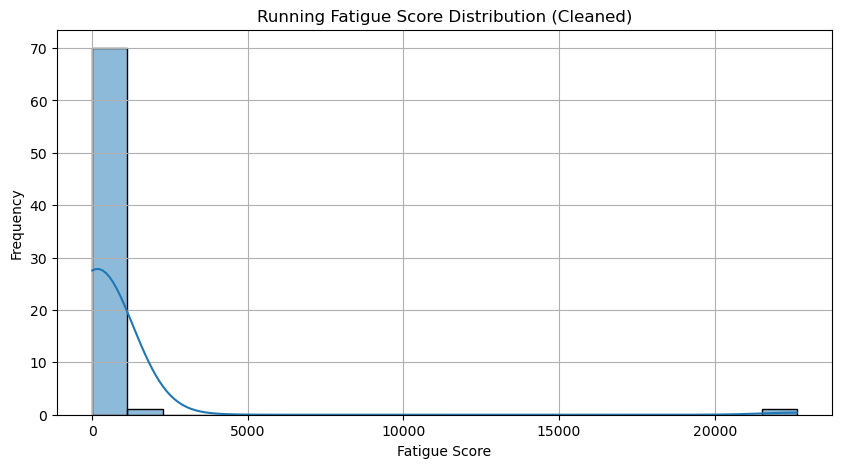

In [10]:
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered['Fatigue Score'], kde=True, bins=20)
plt.title("Running Fatigue Score Distribution (Cleaned)")
plt.xlabel("Fatigue Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


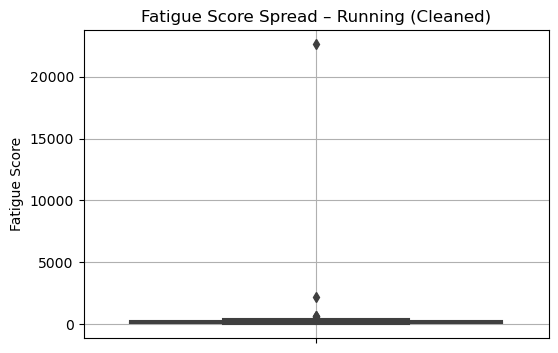

In [11]:
# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_filtered['Fatigue Score'])
plt.title("Fatigue Score Spread – Running (Cleaned)")
plt.ylabel("Fatigue Score")
plt.grid(True)
plt.show()


# Summary Findings for Team Review – Running Fatigue Analysis

- **Dataset**: `Fixed_cleaned_activities.csv` from the ReflexionPro Running Archive.
- **Method**: Fatigue Score calculated as `Duration (min) × Net Elevation Gain`.
- **Data Cleaning**: Removed sessions with zero or negative duration/elevation. Resulting in 72 valid entries.
- **Distribution**:
  - Most running sessions had low-to-moderate fatigue scores (median ≈ 132.5).
  - Fatigue scores were **right-skewed**, with rare but significant outliers above 10,000.
- **Visual Insights**:
  - Histogram shows a sharp drop-off after 500–1000 score.
  - Boxplot highlights the presence of a few intense sessions.
- **Conclusion**: 
  - The running dataset reflects mostly consistent effort with occasional spikes in fatigue.
  - The analysis structure is aligned with the cycling notebook for integration and dashboard use.
  - Cleaned fatigue scores are now ready for use in leaderboard ranking, athlete load tracking, or predictive modelling.


# Compare with Cycling

**Load Original Cycling File**

In [22]:
# Load the original cycling dataset
cycling_url = "https://raw.githubusercontent.com/redbackoperations/Projects/main/Sports%20Performance%20Analysis/frontend/Cycling%20Analysis/data/extended_activities.csv"
df_cycling = pd.read_csv(cycling_url)


**Process Cycling Fatigue Data (Same as Running)**

In [23]:
# Calculate duration in minutes and net elevation gain
df_cycling['Duration (min)'] = df_cycling['Elapsed Time'] / 60
df_cycling['Net Elevation Gain'] = df_cycling['Elevation Gain'] - df_cycling['Elevation Loss']

# Filter out bad data
df_cycling_filtered = df_cycling[
    (df_cycling['Duration (min)'] > 0) &
    (df_cycling['Net Elevation Gain'] > 0)
].copy()

# Calculate fatigue score
df_cycling_filtered['Fatigue Score'] = df_cycling_filtered['Duration (min)'] * df_cycling_filtered['Net Elevation Gain']
df_cycling_filtered['Sport'] = 'Cycling'


**Tag Running and Combine for Comparison**

In [24]:
# Tag running data 
df_filtered['Sport'] = 'Running'

# Merge both sports' fatigue data
df_compare = pd.concat([
    df_filtered[['Fatigue Score', 'Sport']],
    df_cycling_filtered[['Fatigue Score', 'Sport']]
])


**Plot Comparison Boxplot**

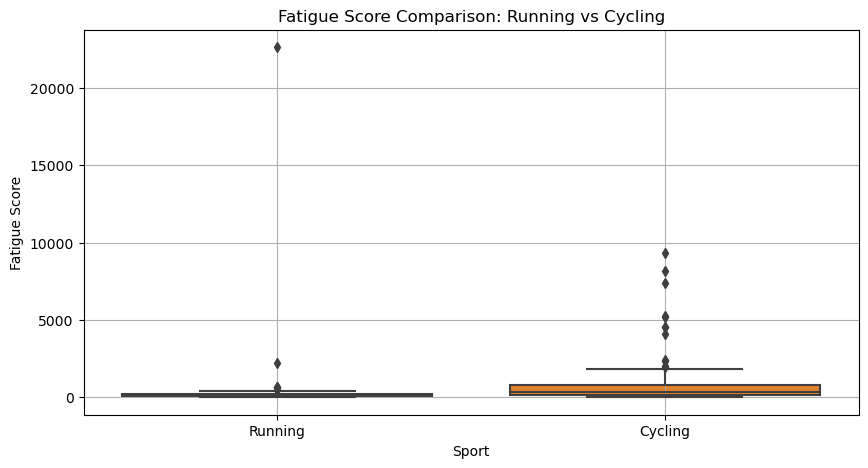

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_compare, x='Sport', y='Fatigue Score')
plt.title("Fatigue Score Comparison: Running vs Cycling")
plt.ylabel("Fatigue Score")
plt.grid(True)
plt.show()


# Cross-Sport Fatigue Score Insights – Running vs Cycling

To ensure consistent and fair comparison across sports, I used the same fatigue formula:
**Fatigue Score = Duration (min) × Net Elevation Gain**

### Implementation Notes:
The original cycling analysis notebook did not use this formula (it used Relative Effort), and the structure of the dataset was different.  
To keep the comparison accurate and fully accessible, I reprocessed the cycling dataset **directly in this notebook** using the same method as the running data.

### Key Observations:
- **Cycling** shows higher fatigue scores overall, due to longer durations and higher elevation.
- **Running** shows a tighter range with fewer extreme outliers.
- Both sports exhibit positively skewed fatigue distributions.

### Why This Approach Matters:
- Ensures methodological consistency
- Makes the notebook fully self-contained and reproducible for team review
- Supports fatigue-based leaderboard design and future performance modelling
